In [6]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
from scipy.spatial.transform import Rotation as R
import time

import planeslam.mesh as mesh
import planeslam.general as general
import planeslam.io as io
from planeslam.scanrep import ScanRep, pc_to_scan

Read in airsim LiDAR and pose data

In [2]:
# Read in point cloud data
binpath = os.path.join(os.getcwd(),'..', 'data', 'airsim', 'blocks_20_samples_1', 'lidar', 'Drone0')
PC_data = io.read_lidar_bin(binpath)

In [3]:
# Read in ground-truth poses (in drone local frame)
posepath = os.path.join(os.getcwd(),'..', 'data', 'airsim', 'blocks_20_samples_1', 'poses', 'Drone0')
drone_positions, drone_orientations = io.read_poses(posepath)

Test a single scan

In [4]:
P = PC_data[3]
start_time = time.time()
P = general.downsample(P, factor=5, axis=0)
m = mesh.lidar_mesh(P)
# Prune the mesh for long edges
m = mesh.prune_mesh(P, m, 10)
# Cluster the mesh with graph search
clusters, avg_normals = mesh.cluster_mesh_graph_search(P, m)
print("elapsed time: ", time.time() - start_time)

elapsed time:  0.7289061546325684


Text(0.5, 0.5, 'Y')

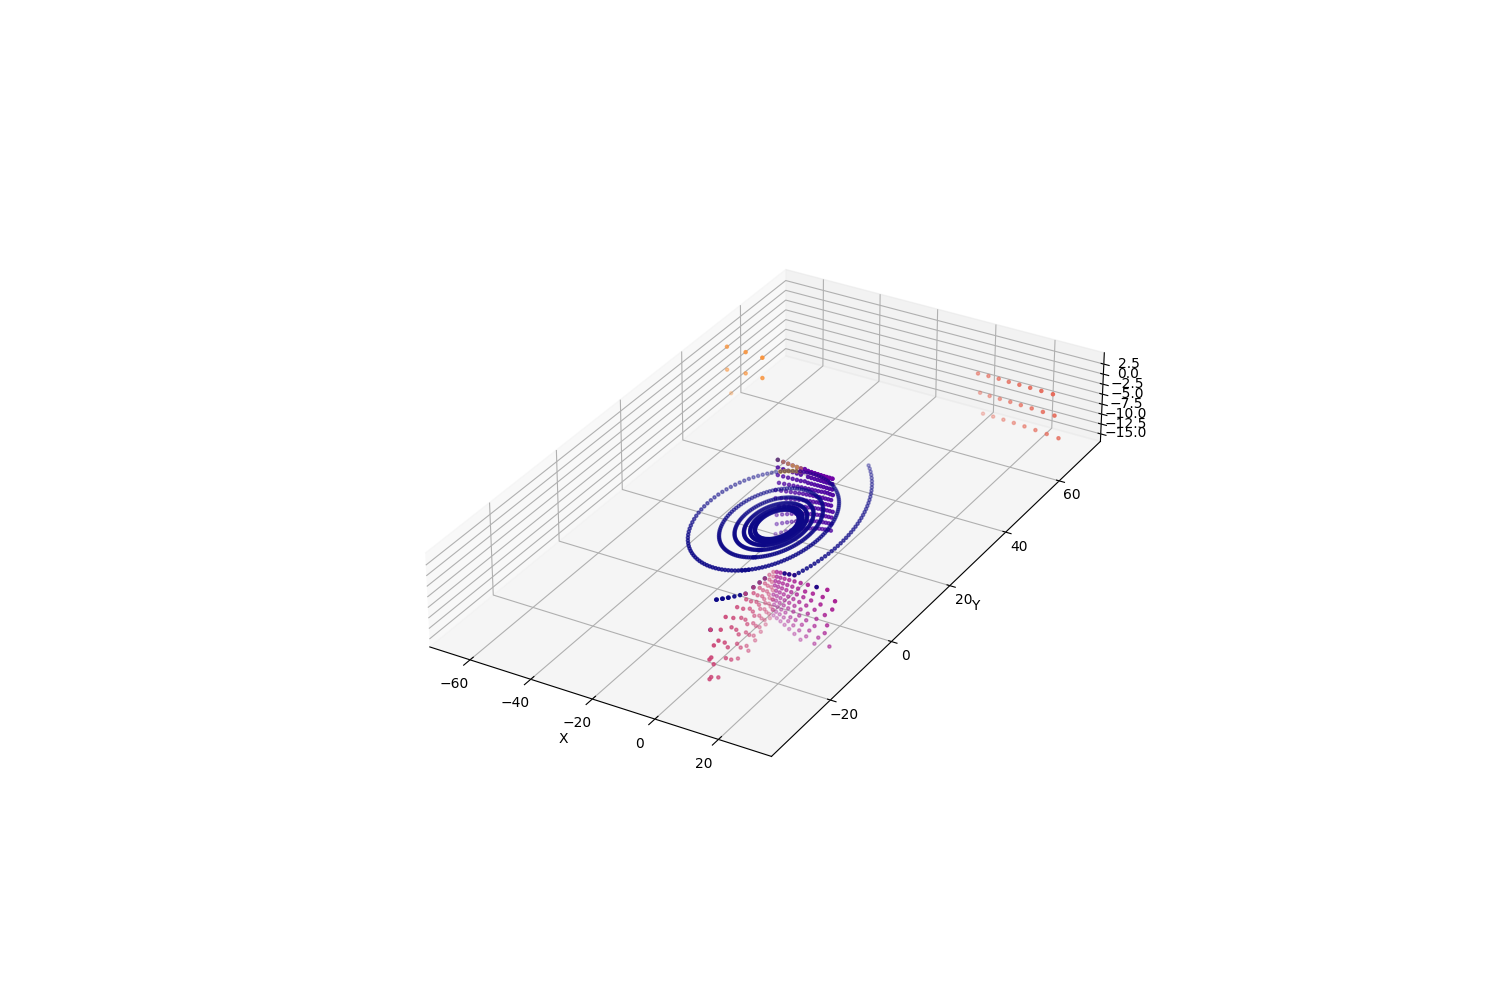

In [7]:
T = P[m.simplices]
centroids = np.mean(T, axis=1)

# Plot clusters
fig = plt.figure(figsize=(15,10))
ax2 = fig.add_subplot(1, 1, 1, projection='3d')
cmap = cm.get_cmap('plasma')
cmap_idxs = int(len(cmap.colors) / len(clusters)) * np.arange(len(clusters))
colors = np.asarray(cmap.colors)[cmap_idxs,:]
for i, c in enumerate(clusters):
    cluster_pts_idxs = np.unique(m.simplices[c,:]) 
    cluster_pts = P[cluster_pts_idxs,:]
    ax2.scatter3D(cluster_pts[:,0], cluster_pts[:,1], cluster_pts[:,2], color=colors[i,:], marker='.')  
ax2.set_box_aspect((np.ptp(P[:,0]), np.ptp(P[:,1]), np.ptp(P[:,2])))
ax2.set_xlabel("X")
ax2.set_ylabel("Y")


In [8]:
vertices, faces, normals = mesh.scan_from_clusters(P, m, clusters, avg_normals)
scan = ScanRep(vertices, faces, normals)

Text(0.5, 0.5, 'Y')

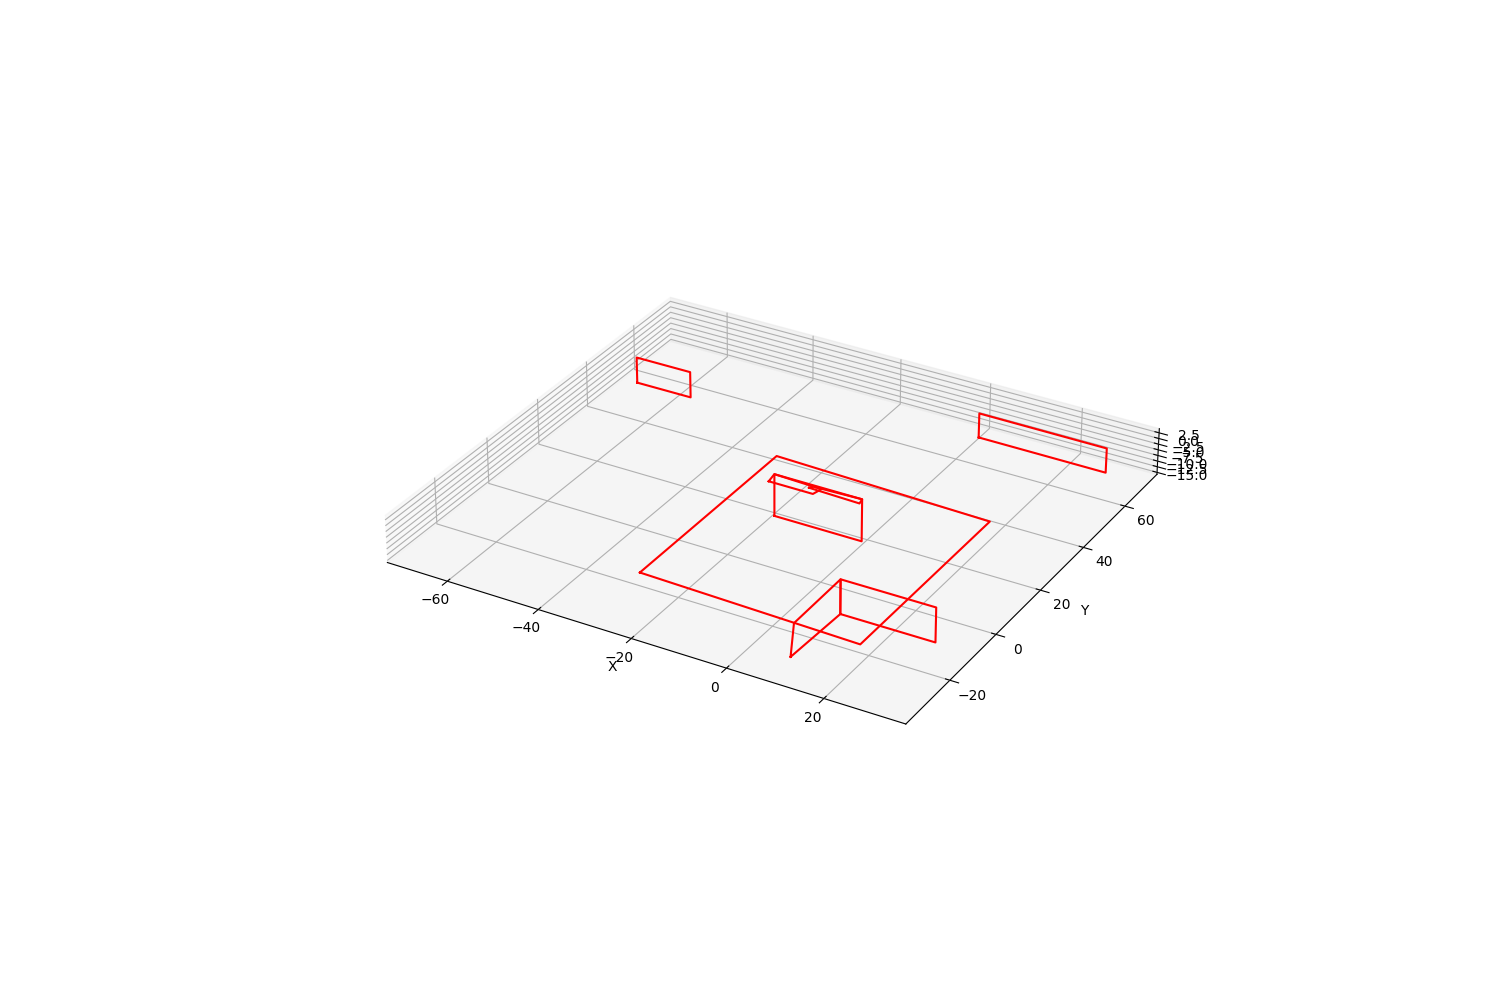

In [9]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

scan.plot(ax, color='r')

ax.set_box_aspect((np.ptp(PC_data[0][:,0]), np.ptp(PC_data[0][:,1]), np.ptp(PC_data[0][:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")

Extract planes for LiDAR scans

In [10]:
num_scans = len(PC_data)
scans = num_scans * [None]
scans_transformed = num_scans * [None]
for i in range(num_scans):
    scans[i] = pc_to_scan(PC_data[i])
    r = R.from_quat(drone_orientations[i,:])
    scans[i].transform(r.as_matrix(), drone_positions[i,:])

Text(0.5, 0.5, 'Y')

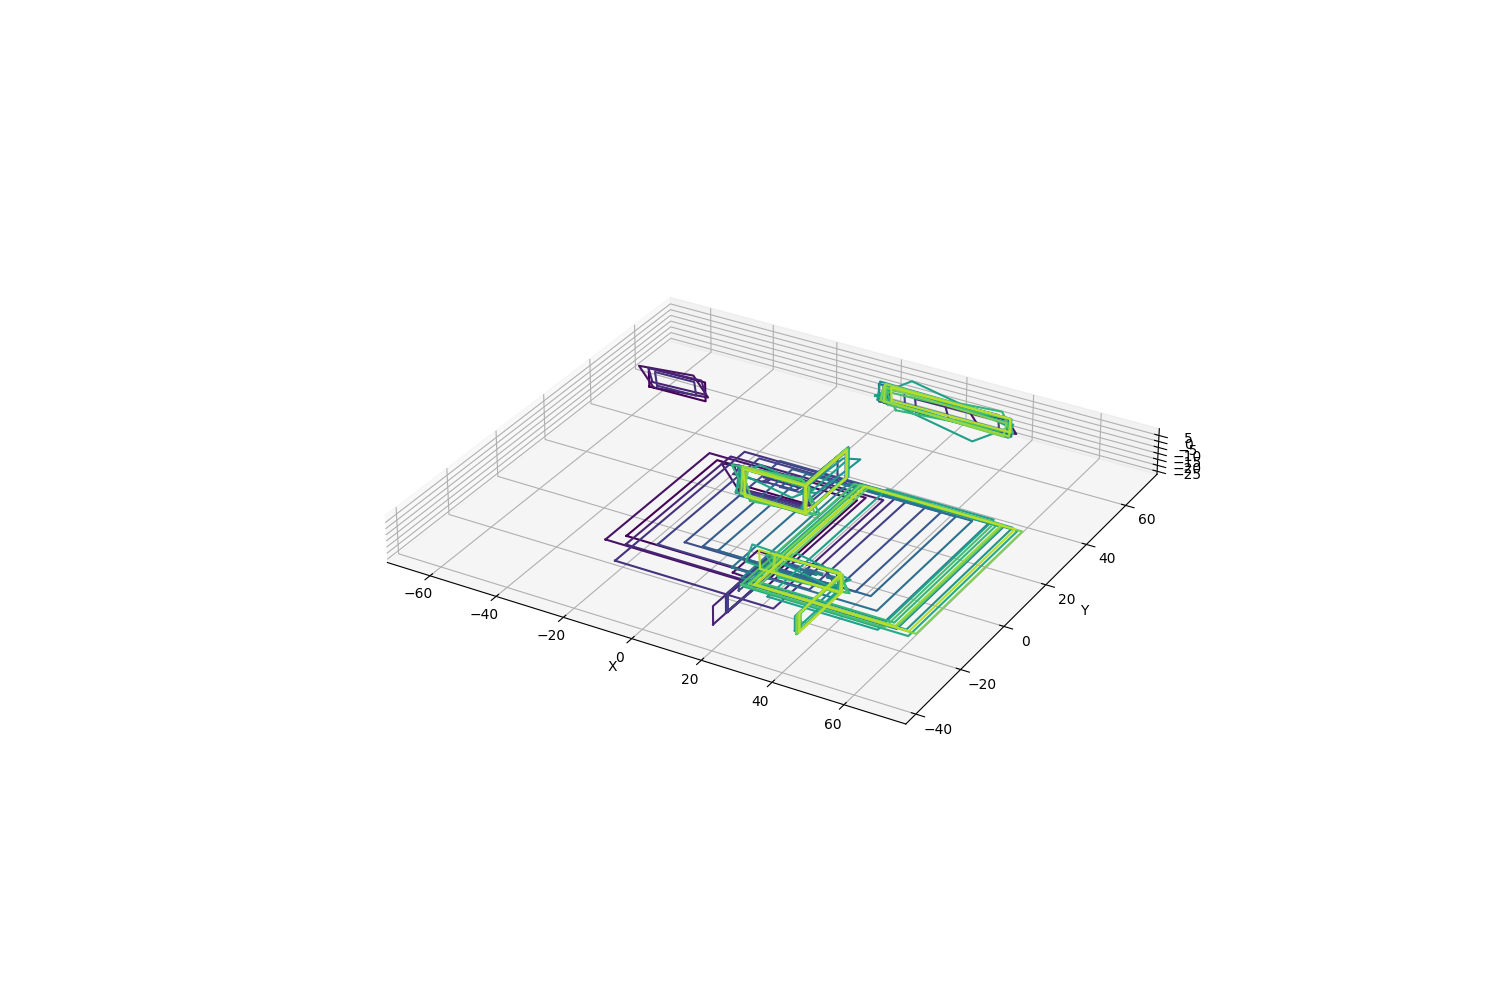

In [11]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
cmap = cm.get_cmap('viridis')
cmap_idxs = int(len(cmap.colors) / num_scans) * np.arange(num_scans)
colors = np.asarray(cmap.colors)[cmap_idxs,:]
for i, s in enumerate(scans):
    s.plot(ax, color=colors[i])
ax.set_box_aspect((np.ptp(PC_data[0][:,0]), np.ptp(PC_data[0][:,1]), np.ptp(PC_data[0][:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")

Merge Scans

In [6]:
import planeslam.geometry as geometry

a = np.array([1,2,3])
b = np.array([-1,2,0])
c = geometry.vector_projection(a, b)

In [ ]:
def merge_scans(scan1, scan2):
    pass

In [8]:
def plane_to_plane_dist(plane_1, normal_1, plane_2, normal_2):
    """Plane-to-Plane distance
    
    Shortest distance between two (rectangularly bounded) planes. Computed
    by taking the centroid to centroid vector, and projecting it along the
    average normal of the two planes, and taking the norm of the projected
    vector. Meant for planes with close normals.

    Parameters
    ----------
    plane_1 : np.array (4 x 3)
        Rectangularly bounded plane represented by 4 vertices
    plane_2 : np.array (4 x 3)
        Rectangularly bounded plane represented by 4 vertices
    
    Returns
    -------
    float
        Plane-to-plane distance
    
    """
    centroid_1 = np.mean(plane_1, axis=0)
    centroid_2 = np.mean(plane_2, axis=0)
    c2c_vector = centroid_1 - centroid_2
    avg_normal = (normal_1 + normal_2) / 2
    return np.linalg.norm(geometry.vector_projection(c2c_vector, avg_normal))


In [10]:
scan_1 = scans[0]
scan_2 = scans[1]

face_1 = scan_1.faces[0]
plane_1 = scan_1.vertices[face_1]
centroid_1 = np.mean(plane_1, axis=0)
normal_1 = scan_1.normals[0]

face_2 = scan_2.faces[0]
plane_2 = scan_2.vertices[face_2]
centroid_2 = np.mean(plane_2, axis=0)
normal_2 = scan_2.normals[0]

plane_to_plane_dist(plane_1, normal_1, plane_2, normal_2)

0.3401209799366626

In [11]:
def face_correspondences(scan_1, scan_2, norm_thresh=0.1, dist_thresh=1.0):
    for idx_1, face_1 in enumerate(scan_1.faces):
        # Extract vertices and normal
        plane_1 = scan_1.vertices[face_1]
        centroid_1 = np.mean(plane_1, axis=0)
        normal_1 = scan_1.normals[idx_1]
        for idx_2, face_2 in enumerate(scan_2.faces):
            # Extract vertices and normal
            plane_2 = scan_2.vertices[face_2]
            centroid_2 = np.mean(plane_2, axis=0)
            normal_2 = scan_2.normals[idx_2]
            # Check if 2 planes are approximately coplanar
            if np.linalg.norm(normal_1 - normal_2) < norm_thresh:
                print("norm check")
                # Compute plane to plane distance
                if plane_to_plane_dist(plane_1, normal_1, plane_2, normal_2) < dist_thresh:
                    print("dist check")
                    # Check if 2 planes are close to each other 
                    # TODO: replace 
            

In [24]:
np.mean(scans[0].vertices, axis=0)

array([-2.68352057, 10.37289607, -4.37311121])

In [12]:
face_correspondences(scans[0], scans[1])

norm check
dist check
norm check
norm check
norm check
dist check
norm check
norm check
dist check
norm check


Text(0.5, 0.5, 'Y')

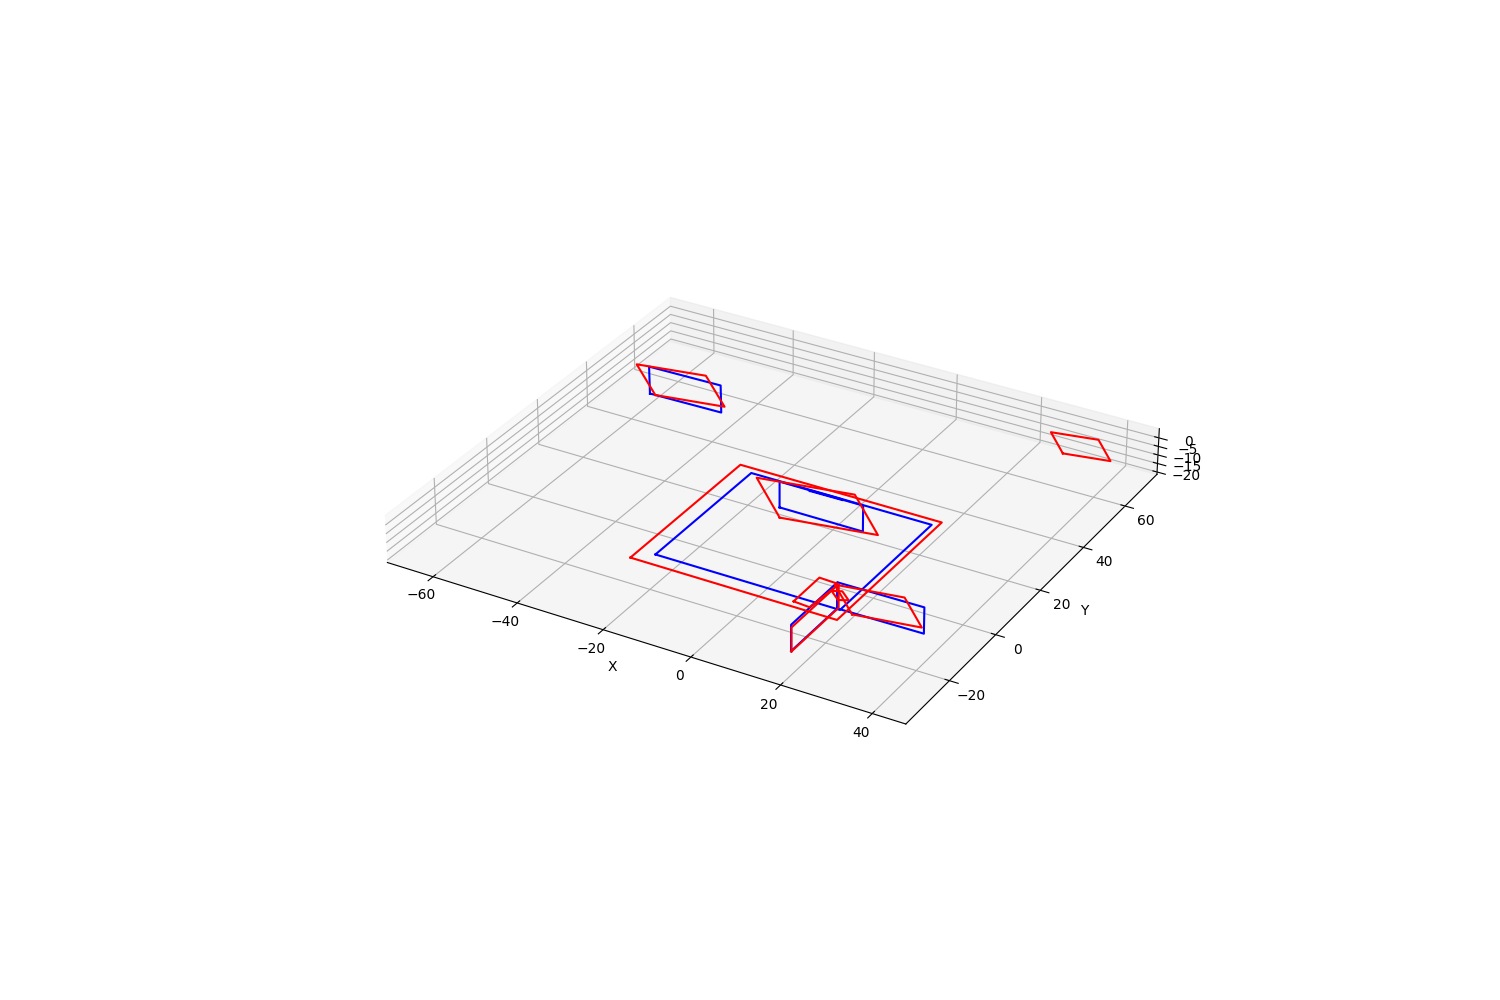

In [13]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

scans[0].plot(ax, color='b')
scans[1].plot(ax, color='r')

ax.set_box_aspect((np.ptp(PC_data[0][:,0]), np.ptp(PC_data[0][:,1]), np.ptp(PC_data[0][:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")